## [ 문제 1 ]  
Fashion MNIST 데이터 정규화를 위한 Mean 과 Std. 값 찾기

In [ ]:
import torch
from torchvision import datasets, transforms

# Fashion-MNIST 데이터셋 불러오기
train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()  # 0~1 범위로 정규화[(0, 255) -> (0, 1)]
)

# 전체 이미지의 픽셀값을 하나의 큰 텐서로 합침
imgs = torch.stack([img for img, _ in train_dataset], dim=0)  # torch shape: [60000, 1, 28, 28]

# 평균과 표준편차 계산 -> 문제 1
mean = imgs.mean()
std = imgs.std()

print(f"Fashion-MNIST 평균: {mean:.4f}")
print(f"Fashion-MNIST 표준편차:  {std:.4f}")


100%|██████████| 26.4M/26.4M [00:01<00:00, 14.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.92MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.6MB/s]


Fashion-MNIST 평균: 0.2860
Fashion-MNIST 표준편차:  0.3530


현재 문제에서 요구하는 것은 코드 내의 0.0, 0.1로 표현되어 있는 평균과 표준편차를 구해 그 자리에 채워넣는 것.

데이터셋을 직접 불러 와 평균과 표준편차를 직접 계산한다.

## [문제 2] Fashion MNIST 데이터에 대하여 CNN 학습시키기



a_fashion_mnist_data.py를 일반 디렉토리 내에서 구동할 수 있도록 수정한 뒤 문제 1에서 구한 평균과 표준편차로 수정한 후 구동한다.

In [ ]:
import os
from pathlib import Path
import torch
import wandb
from torch import nn

from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms

from pathlib import Path
BASE_PATH = "/content"  # 코랩의 기본 경로로 고정
print(BASE_PATH)

import sys

sys.path.append(BASE_PATH)

from utils import get_num_cpu_cores, is_linux, is_windows


def get_fashion_mnist_data():
    data_path = "./data"

    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    print("Num Train Samples: ", len(f_mnist_train))
    print("Num Validation Samples: ", len(f_mnist_validation))
    print("Sample Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])

    num_data_loading_workers = get_num_cpu_cores() if is_linux() or is_windows() else 0
    print("Number of Data Loading Workers:", num_data_loading_workers)

    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=wandb.config.batch_size,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.2860, std=0.3530),
    )

    return train_data_loader, validation_data_loader, f_mnist_transforms


def get_fashion_mnist_test_data():
    data_path = os.path.join(BASE_PATH, "j_fashion_mnist")

    f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

    print("Num Test Samples: ", len(f_mnist_test))
    print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.2860, std=0.3530),
    )

    return f_mnist_test_images, test_data_loader, f_mnist_transforms


if __name__ == "__main__":
    config = {'batch_size': 2048, }
    wandb.init(mode="disabled", config=config)

    train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data()
    print()
    f_mnist_test_images, test_data_loader, f_mnist_transforms = get_fashion_mnist_test_data()


/content


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
100%|██████████| 26.4M/26.4M [00:02<00:00, 10.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.37MB/s]


Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 2



100%|██████████| 26.4M/26.4M [00:02<00:00, 13.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.7MB/s]

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])


무해한 코랩 관련 오류를 제하고 정상적으로 코드가 수행되어 분할과 테스트 데이터가 정상적으로 로드된 것을 확인할 수 있다.

In [ ]:
!pip install wandb
import wandb
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jamespk0725 (jamespk0725-korea-university-of-technology-and-education) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


출력 확인을 위해 wandb와 연동.

In [ ]:
!pip install torchinfo

torchinfo를 다운한 뒤, 우리가 지금부터 사용할 a_mnist_train_cnn.py도 Fashion-MNIST 학습용으로 수정한다.  
로더와 함수 이름 및 변수 이름들만 변경해주면 된다.

In [ ]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

import sys
sys.path.append(BASE_PATH)

from c_trainer import ClassificationTrainer
from a_fashion_mnist_data import get_fashion_mnist_data
from e_arg_parser import get_parser

def get_cnn_model():
  class MyModel(nn.Module):
    def __init__(self, in_channels, n_output):
      super().__init__()

      self.model = nn.Sequential(
        # B x 1 x 28 x 28 --> B x 6 x (28 - 5 + 1) x (28 - 5 + 1) = B x 6 x 24 x 24
        nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=(5, 5), stride=(1, 1)),
        # B x 6 x 24 x 24 --> B x 6 x 12 x 12
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        # B x 6 x 12 x 12 --> B x 16 x (12 - 5 + 1) x (12 - 5 + 1) = B x 16 x 8 x 8
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=(1, 1)),
        # B x 16 x 8 x 8 --> B x 16 x 4 x 4
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        # B x 16 x 4 x 4 --> B x 256
        nn.Flatten(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, n_output),
      )

    def forward(self, x):
      x = self.model(x)
      return x

  # 1 * 28 * 28
  my_model = MyModel(in_channels=1, n_output=10)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta
  }

  project_name = "cnn_mnist"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="mnist experiment with cnn",
    tags=["cnn", "mnist"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data()
  model = get_cnn_model()
  model.to(device)

  from torchinfo import summary
  summary(model=model, input_size=(1, 1, 28, 28))

  optimizer = optim.SGD(model.parameters(), lr=wandb.config.learning_rate)

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, f_mnist_transforms,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args()
  main(args)
  # python _01_code/_11_cnn/a_mnist_train_cnn.py --wandb -b 2048 -r 1e-3 -v 10
  # python _01_code/_11_cnn/a_mnist_train_cnn.py --no-wandb -b 2048 -r 1e-3 -v 10

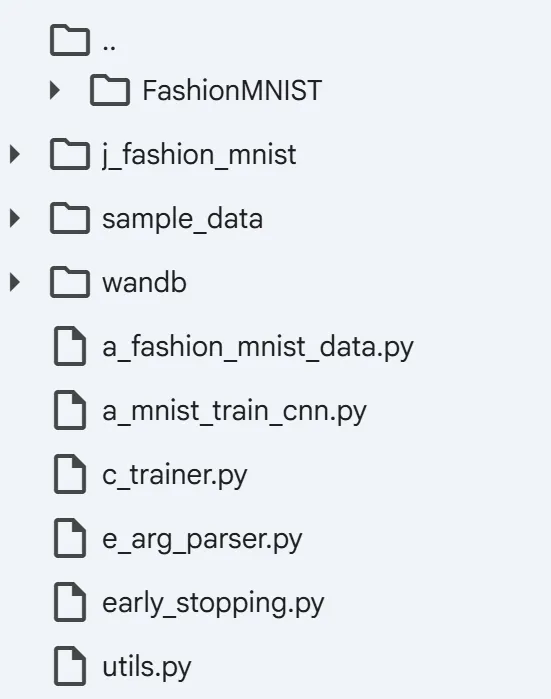

참고로 이 시점의 코랩의 세션 디렉토리는 다음과 같다.

In [ ]:
%run a_mnist_train_cnn.py --wandb -b 512 -r 1e-3 -v 1 --epochs 35

Namespace(wandb=True, batch_size=512, epochs=35, learning_rate=0.001, validation_intervals=1, early_stop_patience=10, early_stop_delta=1e-05)
{'epochs': 35, 'batch_size': 512, 'validation_intervals': 1, 'learning_rate': 0.001, 'early_stop_patience': 10, 'early_stop_delta': 1e-05}
Training on device cuda:0.
Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 2
[Epoch   1] T_loss: 2.23413, T_accuracy: 20.2364 | V_loss: 2.16496, V_accuracy: 27.7000 | Early stopping is stated! | T_time: 00:00:07, T_speed: 0.143
[Epoch   2] T_loss: 2.07251, T_accuracy: 36.7200 | V_loss: 1.96758, V_accuracy: 43.1800 | V_loss decreased (2.16496 --> 1.96758). Saving model... | T_time: 00:00:12, T_speed: 0.167
[Epoch   3] T_loss: 1.78765, T_accuracy: 52.2218 | V_loss: 1.61577, V_accuracy: 56.3600 | V_loss decreased (1.96758 --> 1.61577). Saving model... | T_time: 00:00:19, T_speed: 0.158
[Epoch   4] T_loss: 1.42065, T_accuracy: 61.0455 |

Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
Training accuracy (%),▁▃▅▆▆▇▇▇▇▇▇▇▇▇█████████████████████
Training loss,█▇▆▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁█▅▆▅▄▄▄▄▄▄▄▄▄▄▄▄▅▄▅▄▅▅▅▅▄▅▄▅▄▅▅▅▅▅
Validation accuracy (%),▁▃▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
Validation loss,█▇▆▄▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,35
Training accuracy (%),78.14182
Training loss,0.57905
Training speed (epochs/sec.),0.15556
Validation accuracy (%),75.88


해당 코드를 시험삼아 에포크 30~35개로 계속 돌려봤지만, V-Acuuracy를 90 이상으로 끌어올리는 건 쉽지 않아 보인다.

  전반적인 구조 개선이 필요한 것을 판단, 전반적인 코드 자체를 수정한다.

In [ ]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

import sys
sys.path.append(BASE_PATH)

from c_trainer import ClassificationTrainer
from a_fashion_mnist_data import get_fashion_mnist_data
from e_arg_parser import get_parser


def get_cnn_model():
  """
  Lenet에서 배치 정규화 및 드롭아웃이 들어간 깊은 CNN으로 교체. Val_Acc를 90%대까지 끌어들이기 위한 몸부림..
  1) Convolution 레이어를 3개로 늘리고, 각 Convolution 블록 뒤에 BatchNorm 추가
  2) MaxPool과 Dropout 추가로 오버피팅 억제
  """
  class MyModel(nn.Module):
    def __init__(self, in_channels, n_output):
      super().__init__()

      # Conv + BN + ReLU + MaxPool + Dropout
      self.features = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        # 32 x 28 x 28 → 64 x 28 x 28
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        # 64 x 28 x 28 → 64 x 14 x 14
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.25),

        # 64 x 14 x 14 → 128 x 14 x 14
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        # 128 x 14 x 14 → 128 x 7 x 7
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.25),
      )

      # 분류기
      # Flatten → FC 256 → FC 10
      self.classifier = nn.Sequential(
        nn.Flatten(),                 # 128 * 7 * 7 = 6272
        nn.Linear(128 * 7 * 7, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, n_output),
      )

    def forward(self, x):
      x = self.features(x)
      x = self.classifier(x)
      return x

  # 입력: 1 x28 x28 / 출력 클래스: 10
  my_model = MyModel(in_channels=1, n_output=10)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta
  }

  project_name = "cnn_mnist"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="fashion-mnist experiment with improved cnn",
    tags=["cnn", "fashion-mnist"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data()
  model = get_cnn_model()
  model.to(device)

  from torchinfo import summary
  summary(model=model, input_size=(1, 1, 28, 28))

  # 옵티마이저 강화: Adam + weight_decay
  # RMSProp는 쓸 때마다 손실이 자꾸 튀겨서 못써먹을 물건이었다
  optimizer = optim.Adam(
    model.parameters(),
    lr=wandb.config.learning_rate,
    weight_decay=5e-5,  # 오버피팅 좀 줄이기
  )

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, f_mnist_transforms,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args()
  main(args)

  # python _01_code/_11_cnn/a_mnist_train_cnn.py --wandb -b 512 -r 1e-3 -v 1 --epochs 30
  # python _01_code/_11_cnn/a_mnist_train_cnn.py --no-wandb -b 512 -r 1e-3 -v 1 --epochs 30


**옵티마이저**(SGD -> Adam + weight_decay),  
**LeNet**에서 **배치 정규화 및 드롭아웃**으로 수정.  
또한 **에포크**도 50으로 수정해본다.  
조금이라도 값 보정을 위해 weight decay는 5e-5로 설정.

## 사용 하이퍼파라미터
#### 모델 구조
- 기본 LeNet 대신 3개의 합성곱 블록 + 배치 정규화 + 풀링 + 드롭아웃 사용.
  - Conv(1->32), BatchNorm, ReLU
  - Conv(32->64), BatchNorm, ReLU, MaxPool, Dropout(0.25)
  - Conv(64->128), BatchNorm, ReLU, MaxPool, Dropout(0.25)

#### 정규화
- 합성곱 블록 뒤에 BatchNorm2d.
- 입력 이미지 정규화는 Normalize(mean=0.2860, std=0.3530)... 그러니까 문제 1에서 구했던 값으로.


#### Optimizer: Adam
- Accuracy 보정을 위한 SGD 대신 ADAM  + Weight decay 사용

#### Learning rate:  1e-3 사용 (0.001).
- 테스트해 본 결과 1e-3 부근이 수렴 속도와 안정성이 가장 괜찮아서 최종 선택.

#### Batch size
- 그대로 512 사용.

#### Weight decay: 5e-5

- 과적합 완화해주면서 Accuracy를 높여줄 수 있을 거라는 생각에 5e-5로 변경..

#### Dropout Rate : 0.25/0.5
- FC(완전연결층) 레이어 전이야 파라미터 수가 많으므로 크게 설정해도 무리없지만, Conv 레이어는 파라미터수가 적으므로 의도적으로 그 절반인 0.25를 할당.

#### 에포크 : 50
- 넉넉하게 50으로 잡았으나, 40으로 해도 문제는 없었을 듯.

#### Early Stopiing Patience
- early_stopping.py에서 제공한 기본 디폴트 수치인 10을 사용. delta는 1e-5.

#### 기타 하이퍼파라미터
- 다른 하이퍼파라미터들은 기본 코드에서 제시해 준 하이퍼파라미터들을 변경하지 않고 기본적으로 사용하였다. _99_common_utils 폴더의 얼리 스토핑도 사용.

In [ ]:
%run a_mnist_train_cnn.py --wandb -b 512 -r 1e-3 -v 1 --epochs 50

wandb: Currently logged in as: jamespk0725 (jamespk0725-korea-university-of-technology-and-education) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Namespace(wandb=True, batch_size=512, epochs=50, learning_rate=0.001, validation_intervals=1, early_stop_patience=10, early_stop_delta=1e-05)
{'epochs': 50, 'batch_size': 512, 'validation_intervals': 1, 'learning_rate': 0.001, 'early_stop_patience': 10, 'early_stop_delta': 1e-05}
Training on device cuda:0.
Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 2
[Epoch   1] T_loss: 0.65719, T_accuracy: 76.3964 | V_loss: 0.36376, V_accuracy: 87.1000 | Early stopping is stated! | T_time: 00:00:06, T_speed: 0.167
[Epoch   2] T_loss: 0.36848, T_accuracy: 86.8200 | V_loss: 0.29745, V_accuracy: 89.0000 | V_loss decreased (0.36376 --> 0.29745). Saving model... | T_time: 00:00:14, T_speed: 0.143
[Epoch   3] T_loss: 0.31957, T_accuracy: 88.4873 | V_loss: 0.25910, V_accuracy: 90.4200 | V_loss decreased (0.29745 --> 0.25910). Saving model... | T_time: 00:00:20, T_speed: 0.150
[Epoch   4] T_loss: 0.29345, T_accuracy: 89.4400 |

Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
Training accuracy (%),▁▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
Training loss,█▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),█▁▃▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy (%),▁▃▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇███▇█▇███▇███████████
Validation loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▂▂
Epoch,42
Training accuracy (%),96.39273
Training loss,0.09303
Training speed (epochs/sec.),0.14286
Validation accuracy (%),93.7


93.7이라는 고통스러운 결과가 나왔다.  
94를 어떻게든 넘기기 위해 한 번 다시 돌려 본다.

In [ ]:
%run a_mnist_train_cnn.py --wandb -b 512 -r 1e-3 -v 1 --epochs 50

Namespace(wandb=True, batch_size=512, epochs=50, learning_rate=0.001, validation_intervals=1, early_stop_patience=10, early_stop_delta=1e-05)
{'epochs': 50, 'batch_size': 512, 'validation_intervals': 1, 'learning_rate': 0.001, 'early_stop_patience': 10, 'early_stop_delta': 1e-05}
Training on device cuda:0.
Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 2
[Epoch   1] T_loss: 0.68162, T_accuracy: 76.1764 | V_loss: 0.33804, V_accuracy: 87.4000 | Early stopping is stated! | T_time: 00:00:07, T_speed: 0.143
[Epoch   2] T_loss: 0.37688, T_accuracy: 86.4509 | V_loss: 0.28137, V_accuracy: 88.9000 | V_loss decreased (0.33804 --> 0.28137). Saving model... | T_time: 00:00:14, T_speed: 0.143
[Epoch   3] T_loss: 0.33274, T_accuracy: 88.2145 | V_loss: 0.24517, V_accuracy: 90.9000 | V_loss decreased (0.28137 --> 0.24517). Saving model... | T_time: 00:00:21, T_speed: 0.143
[Epoch   4] T_loss: 0.30466, T_accuracy: 89.1636 |

Epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
Training accuracy (%),▁▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
Training loss,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),████████▃█▄▄▄▁▅▂▅▃▃▃▃▄▄▄▄▄▃▄▃▅▃▅▄
Validation accuracy (%),▁▂▄▅▅▆▅▆▆▆▇▇▇▇▇▇▇█▇▇▇████████████
Validation loss,█▆▄▄▄▃▄▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁
Epoch,33
Training accuracy (%),95.61455
Training loss,0.1162
Training speed (epochs/sec.),0.14103
Validation accuracy (%),94.14


Validation accuracy가 결국 94를 넘겼다.  
조금 강하게 레귤레이션이 걸려서 마지막 1%를 확보하지 못했던 것 같다.  

## [문제 3] 학습 완료된 모델로 테스트 데이터 Accuracy 확인하기

In [ ]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = str(Path(__file__).resolve().parent.parent.parent) # BASE_PATH: /Users/yhhan/git/link_dl
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

import sys
sys.path.append(BASE_PATH)

from c_trainer import ClassificationTrainer
from a_fashion_mnist_data import get_fashion_mnist_data, get_fashion_mnist_test_data
from e_arg_parser import get_parser


def get_cnn_model():
  """
  Lenet에서 배치 정규화 및 드롭아웃이 들어간 깊은 CNN으로 교체. Val_Acc를 90%대까지 끌어들이기 위한 몸부림..
  1) Convolution 레이어를 3개로 늘리고, 각 Convolution 블록 뒤에 BatchNorm 추가
  2) MaxPool과 Dropout 추가로 오버피팅 억제
  """
  class MyModel(nn.Module):
    def __init__(self, in_channels, n_output):
      super().__init__()

      # Conv + BN + ReLU + MaxPool + Dropout
      self.features = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        # 32 x 28 x 28 → 64 x 28 x 28
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        # 64 x 28 x 28 → 64 x 14 x 14
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.25),

        # 64 x 14 x 14 → 128 x 14 x 14
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        # 128 x 14 x 14 → 128 x 7 x 7
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.25),
      )

      # 분류기
      # Flatten → FC 256 → FC 10
      self.classifier = nn.Sequential(
        nn.Flatten(),                 # 128 * 7 * 7 = 6272
        nn.Linear(128 * 7 * 7, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, n_output),
      )

    def forward(self, x):
      x = self.features(x)
      x = self.classifier(x)
      return x

  # 입력: 1 x28 x28 / 출력 클래스: 10
  my_model = MyModel(in_channels=1, n_output=10)

  return my_model

def evaluate_on_test(model, device):
    """
    문제 3 함수 / 학습 완료된 모델로 Fashion-MNIST 테스트 데이터(10,000) 샘플에 대한 손실(loss)과 정확도(accuracy)를 계산하는 함수
    """
    # 1) 테스트 데이터 로더
    f_mnist_test_images, test_loader, test_transforms = get_fashion_mnist_test_data()

    model.eval()
    criterion = nn.CrossEntropyLoss()

    total_loss = 0.0
    total_correct = 0
    total = 0

    # 2) 테스트 데이터에 대한 손실과 정확도 계산
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb = test_transforms(xb)          # train/val과 동일 정규화
            logits = model(xb)
            loss = criterion(logits, yb)
            # 누적
            total_loss += loss.item() * yb.size(0)
            preds = logits.argmax(1)
            total_correct += (preds == yb).sum().item()
            total += yb.size(0)
    # 최종 Loss와 Accuracy 계산
    test_loss = total_loss / total
    test_acc = total_correct / total
    # 3) 결과 출력
    print(f"[Test] loss: {test_loss:.4f}, accuracy: {test_acc*100:.2f}%")

    return test_loss, test_acc

def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta
  }

  project_name = "cnn_mnist"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="fashion-mnist experiment with improved cnn",
    tags=["cnn", "fashion-mnist"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data()
  model = get_cnn_model()
  model.to(device)

  from torchinfo import summary
  summary(model=model, input_size=(1, 1, 28, 28))

  # 옵티마이저 강화: Adam + weight_decay
  # RMSProp는 쓸 때마다 손실이 자꾸 튀겨서 못써먹을 물건이었다
  optimizer = optim.Adam(
    model.parameters(),
    lr=wandb.config.learning_rate,
    weight_decay=5e-5,  # 오버피팅 좀 줄이기
  )

  classification_trainer = ClassificationTrainer(
      project_name, model, optimizer, train_data_loader, validation_data_loader, f_mnist_transforms,
      run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  # 학습 완료된 모델로 Test Accuracy 계산
  test_loss, test_acc = evaluate_on_test(model, device)

  if args.wandb:
      wandb.run.summary["test_loss"] = test_loss
      wandb.run.summary["test_acc"] = test_acc

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args()
  main(args)

  # python _01_code/_11_cnn/a_mnist_train_cnn.py --wandb -b 512 -r 1e-3 -v 1 --epochs 30
  # python _01_code/_11_cnn/a_mnist_train_cnn.py --no-wandb -b 512 -r 1e-3 -v 1 --epochs 30


이제 문제 3으로 가, Test Accuracy를 계산할 시간이다.  
evaluate_on_test() 함수와 메인 함수에 test 평가 호출을 추가한다.  
중요한 건 ClassificationTrainer가 model을 내부적으로 학습시키기 때문에
train_loop() 끝난 뒤 model은 이미 학습 완료된 상태라는 것,  
  
그 model을 그대로 evaluate_on_test에 넘겨서
test 데이터 10,000장에 대한 Accuracy를 한 번에 측정하는 것이다.

In [ ]:
%run a_mnist_train_cnn.py --wandb -b 512 -r 1e-3 --epochs 50 -v 1

Namespace(wandb=True, batch_size=512, epochs=50, learning_rate=0.001, validation_intervals=1, early_stop_patience=10, early_stop_delta=1e-05)
{'epochs': 50, 'batch_size': 512, 'validation_intervals': 1, 'learning_rate': 0.001, 'early_stop_patience': 10, 'early_stop_delta': 1e-05}
Training on device cuda:0.
Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 2
[Epoch   1] T_loss: 0.78066, T_accuracy: 73.2509 | V_loss: 0.40888, V_accuracy: 85.1000 | Early stopping is stated! | T_time: 00:00:09, T_speed: 0.111
[Epoch   2] T_loss: 0.42049, T_accuracy: 84.7182 | V_loss: 0.32085, V_accuracy: 88.7200 | V_loss decreased (0.40888 --> 0.32085). Saving model... | T_time: 00:00:16, T_speed: 0.125
[Epoch   3] T_loss: 0.35269, T_accuracy: 87.5436 | V_loss: 0.27795, V_accuracy: 89.9600 | V_loss decreased (0.32085 --> 0.27795). Saving model... | T_time: 00:00:23, T_speed: 0.130
[Epoch   4] T_loss: 0.32247, T_accuracy: 88.4927 |

Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
Training accuracy (%),▁▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
Training loss,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▄▆▅▇▆▇▇█▇█▇█████████████████████████
Validation accuracy (%),▁▄▅▅▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇████████████████
Validation loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂
Epoch,37
Training accuracy (%),95.50545
Training loss,0.11951
Training speed (epochs/sec.),0.14015
Validation accuracy (%),93.7


validation accuracy도 반올림해 94에 근접하고, test accuracy도 0,93을 넘겼다.

## [문제 4] 샘플 테스트 데이터 분류 예측 결과 확인하기  
샘플 10개 뽑아서 예측·정답·일치 여부 체크 + 오답 1개 분석

In [ ]:
save_path = os.path.join(CURRENT_FILE_PATH, "best_val_model.pt")
torch.save(model.state_dict(), save_path)
print(f"Saved trained model to: {save_path}")

해당 구문을 main 함수에 추가해 모델을 저장해 문제 4에서 이용한다.
일단 한번 더 학습 돌리기.

In [ ]:
%run a_mnist_train_cnn.py --wandb -b 512 -r 1e-3 --epochs 50 -v 1

/content


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: jamespk0725 (jamespk0725-korea-university-of-technology-and-education) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Namespace(wandb=True, batch_size=512, epochs=50, learning_rate=0.001, validation_intervals=1, early_stop_patience=10, early_stop_delta=1e-05)
{'epochs': 50, 'batch_size': 512, 'validation_intervals': 1, 'learning_rate': 0.001, 'early_stop_patience': 10, 'early_stop_delta': 1e-05}
Training on device cuda:0.


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.94MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.76MB/s]


Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 2
[Epoch   1] T_loss: 0.69003, T_accuracy: 75.7782 | V_loss: 0.37039, V_accuracy: 86.2000 | Early stopping is stated! | T_time: 00:00:08, T_speed: 0.125
[Epoch   2] T_loss: 0.39556, T_accuracy: 85.8200 | V_loss: 0.28960, V_accuracy: 89.1400 | V_loss decreased (0.37039 --> 0.28960). Saving model... | T_time: 00:00:14, T_speed: 0.143
[Epoch   3] T_loss: 0.33302, T_accuracy: 88.1400 | V_loss: 0.25947, V_accuracy: 90.6200 | V_loss decreased (0.28960 --> 0.25947). Saving model... | T_time: 00:00:22, T_speed: 0.136
[Epoch   4] T_loss: 0.30617, T_accuracy: 89.0145 | V_loss: 0.25699, V_accuracy: 90.1600 | V_loss decreased (0.25947 --> 0.25699). Saving model... | T_time: 00:00:28, T_speed: 0.143
[Epoch   5] T_loss: 0.28430, T_accuracy: 89.7418 | V_loss: 0.23494, V_accuracy: 90.6000 | V_loss decreased (0.25699 --> 0.23494). Saving model... | T_time: 00:00:36, T_speed: 0.

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.0MB/s]


Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
[Test] loss: 0.2084, accuracy: 93.31%


Epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
Training accuracy (%),▁▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████
Training loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁█▅█▆██████▇█▇▆▇▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇
Validation accuracy (%),▁▄▅▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████▇█████
Validation loss,█▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,31
Training accuracy (%),95.35273
Training loss,0.12325
Training speed (epochs/sec.),0.13964
Validation accuracy (%),94.1


이상적인 결과가 나왔다. Validation accuracy가 94를 넘기면서 Test Accuracy도 93을 넘겼다.  
Saved trained model to: /content/best_val_model.pt  
학습에 이용할 모델도 정상적으로 저장된 것을 확인.

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
Using device: cuda
Best validation model loaded.


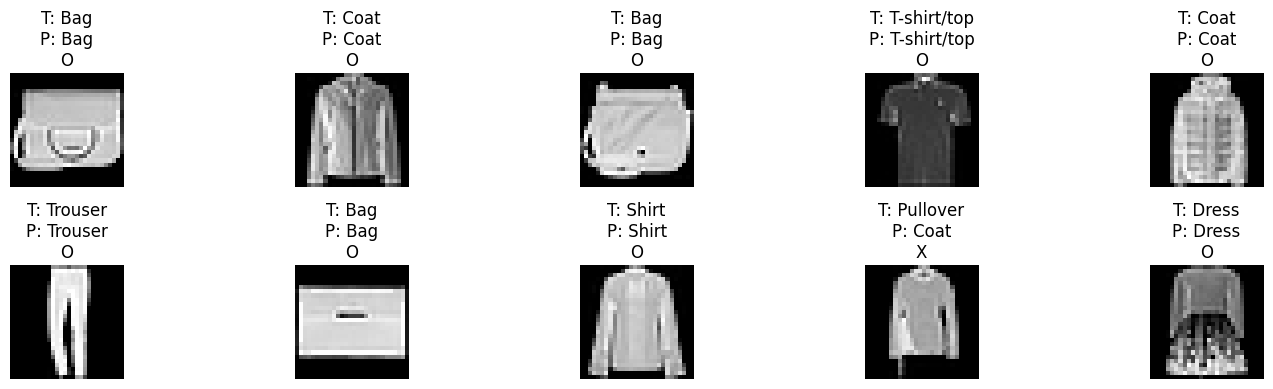

=== 10개 샘플 ===
idx=6084 | T: 8(Bag) | P: 8(Bag) | Correct
idx=5392 | T: 4(Coat) | P: 4(Coat) | Correct
idx=5914 | T: 8(Bag) | P: 8(Bag) | Correct
idx=2391 | T: 0(T-shirt/top) | P: 0(T-shirt/top) | Correct
idx=3430 | T: 4(Coat) | P: 4(Coat) | Correct
idx= 835 | T: 1(Trouser) | P: 1(Trouser) | Correct
idx=4188 | T: 8(Bag) | P: 8(Bag) | Correct
idx=8288 | T: 6(Shirt) | P: 6(Shirt) | Correct
idx=1449 | T: 2(Pullover) | P: 4(Coat) | Wrong
idx=7342 | T: 3(Dress) | P: 3(Dress) | Correct


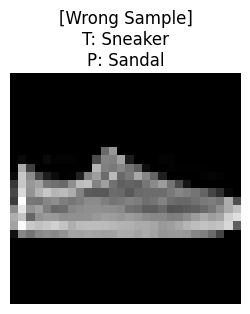

=== 오답 샘플 ===
Index: 12
True Label: 7 (Sneaker)
Pred Label: 5 (Sandal)


In [ ]:
import torch
import random
import matplotlib.pyplot as plt

from a_fashion_mnist_data import get_fashion_mnist_test_data
from a_mnist_train_cnn import get_cnn_model

# 테스트 데이터 로더
f_mnist_test_images, test_loader, test_transforms = get_fashion_mnist_test_data()

# 전체 배치(테스트)를 한 번에 가져오기 batch_size = 10000
images, labels = next(iter(test_loader))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

images = images.to(device)
labels = labels.to(device)

from a_mnist_train_cnn import get_cnn_model

# 모델 생성
model = get_cnn_model().to(device)

# 저장된 best model 가중치 로드
state_dict = torch.load("best_val_model.pt", map_location=device)
model.load_state_dict(state_dict)

model.eval()
print("Best validation model loaded.")

with torch.no_grad():
    x = test_transforms(images)  # train/val과 동일한 정규화
    logits = model(x)
    preds = logits.argmax(dim=1)

# 라벨 이름 (문제 4에서 정의한 10개 클래스)
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# 10개 랜덤 인덱스 선택
num_samples = 10
idxs = random.sample(range(len(images)), num_samples)

plt.figure(figsize=(15, 4))
for i, idx in enumerate(idxs, 1):
    img = images[idx].detach().cpu().squeeze(0)   # [1,28,28] -> [28,28]
    true_label = labels[idx].item()
    pred_label = preds[idx].item()
    is_correct = (true_label == pred_label)

    plt.subplot(2, 5, i)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(
        f"T: {class_names[true_label]}\n"
        f"P: {class_names[pred_label]}\n"
        f"{'O' if is_correct else 'X'}"
    )

plt.tight_layout()
plt.show()

print("=== 10개 샘플 ===")
for idx in idxs:
    t = labels[idx].item()
    p = preds[idx].item()
    print(
        f"idx={idx:4d} | "
        f"T: {t}({class_names[t]}) | "
        f"P: {p}({class_names[p]}) | "
        f"{'Correct' if t == p else 'Wrong'}"
    )
wrong_idxs = (labels != preds).nonzero(as_tuple=False).view(-1)

if len(wrong_idxs) == 0:
    print("모든 테스트 정답")
else:
    idx = wrong_idxs[0].item()  # 첫 번째 오답

    img = images[idx].detach().cpu().squeeze(0)   # [1,28,28] → [28,28]
    true_label = labels[idx].item()
    pred_label = preds[idx].item()

    plt.figure(figsize=(3, 3))
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(
        f"[Wrong Sample]\n"
        f"T: {class_names[true_label]}\n"
        f"P: {class_names[pred_label]}"
    )
    plt.show()

    print("=== 오답 샘플 ===")
    print(f"Index: {idx}")
    print(f"True Label: {true_label} ({class_names[true_label]})")
    print(f"Pred Label: {pred_label} ({class_names[pred_label]})")


오답인 Index 12번 샘플의 실제 레이블은 Sneaker(7)이지만, 모델은 Sandal(5)로 잘못 분류하였다.
이미지를 보니 신발의 윤곽은 뚜렷하지만, 굽의 높이나 발등을 덮는 영역이 샌들과 비슷하게 생겼다보니 낮은 해상도 특성 때문에 디테일이 잘 살지 않은 것으로 보인다.
따라서 모델이 신발의 전체 실루엣에 더 의존하여 Sneaker와 Sandal을 혼동한 것 같다.

## [ 숙제 후기 ]
이번 과제를 진행하면서 단순히 CNN 모델을 구현하는 것을 넘어서, 전체 학습 파이프라인을 제대로 구축하는 경험을 할 수 있었다.  
처음에는 모델 구조만 맞게 만들면 정확도가 자연스럽게 올라갈 것이라 생각했는데, Accuracy가 70%대에서 노는 것을 보고 기겁했다.  
이후에 wegiht decay를 비롯한 하이퍼파라미터들을 조정하고 마지막으로 데이터 전처리, 그 중에서도 몸을 비틀어가며 커스텀한 CNN을 LeNet 대신 사용해 겨우 마의 구간인 94%을 넘길 수 있었다. 여러 하이퍼파라미터중에도 데이터 전처리를 수정하니 제일 극적인 결과가 나왔다.    
이번 과제에는 구글 코랩을 사용했으며, 처음으로 딥러닝다운 딥러닝을 한 귀중한 경험이었던 것 같다. 특히 Accuracy를 끌어올리기 위해 몸을 비트는 과정에서 마주한 몇 번의 시행착오를 거치면서, 정말 많은 것을 배워갈 수 있었던 것 같다.  
마음에 들지 않는 점이라면, 역시 기존의 코드들과 달리 결과가 느려터지게 나와 기다리는 동안 심심했던 것 같다.